In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
# G = c = 1

def lamba_metric(M, R):
    return -0.5*np.log((1-2*G*M/(c**2*R)))

In [4]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _dPhidr(r, P, M):
    factor1 = G/(c**2) 
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return factor1*num/dem

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):
    factor2 = -1 # factor goes in dphi/dr
    term1 = (e+P) 
    dphidr = _dPhidr(r, P, M)
    return factor2 * term1 * dphidr

# DIMENSIONS CHECKED
def _dWdr(r, V, W, phi, dphidr, dedp, omega, lamda, l):
    term1 = (omega**2) * (r**2) * np.exp(lamda - 2*phi)*V
    term2 = dphidr * W * (c**2)
    brackets = term1 + term2
    ret = dedp * brackets - l*(l+1)*np.exp(lamda)*V
    return ret

# DIMENSIONS CHECKED
def _dVdr(r, V, W, dphidr, lamda):
    return 2*dphidr*V - np.exp(lamda)*(W/(r**2))

def coupledTOV(r, VEC, init_params):
    P, M, phi, W, V = VEC
    EOS, l, omega = init_params
    lamda = lamba_metric(M, r)
    
    e = EOS(P)

    eps = 1e-4
    p_eval = np.linspace(P*(1-eps), P*(1+eps), 3)
    e_eval = EOS(p_eval)
    dedp = np.mean(np.gradient(e_eval, p_eval, edge_order=2))

#     dedp = approx_fprime(P, EOS, epsilon = eps)

    #Ideally you need to remove this once you fixed w, v plots. 
#     dedp = min(dedp, 100) # UNPHYSICAL BUT USED TO SATISFY BAD BOUNDARY BEHAVIOUR
    
    if dedp > 100:
        print("ERROR")
        print(dedp)
        print()
    
    drhodp = dedp / (c**2)
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dPhidr = _dPhidr(r, P, M)
    dWdr = _dWdr(r, V, W, phi, dPhidr, drhodp, omega, lamda, l)
    dVdr = _dVdr(r, V, W, dPhidr, lamda)
    ret = [dPdr, dMdr, dPhidr, dWdr, dVdr]
    return ret

In [5]:
def df_to_ep(df):
    n_den = 2.3e14
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.998e10)**2)
    pressure = p*((2.998e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value="extrapolate")
    return f_e_smooth

In [6]:
##### Sanity check that my gradient is working. 

100%|██████████| 225/225 [00:00<00:00, 2535.30it/s]


(0.0, 10.0)

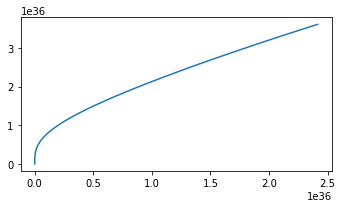

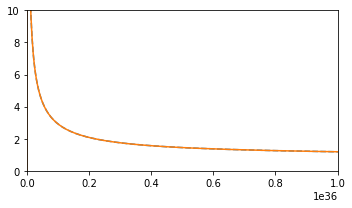

In [17]:
df = pd.read_csv("eos_data/sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)
plt.plot(p, e)
plt.figure()
dedp = np.zeros(len(p))
dedp2 = np.zeros(len(p))
for i in tqdm(range(len(p))):
    eps = 1e-4
    p_eval = np.linspace(p[i]*(1-eps), p[i]*(1), 10)
    e_eval = EOS(p_eval)
#     print(np.gradient(e_eval), edge_order=2)
    dedp[i] = np.gradient(e_eval, p_eval)[0]
    dedp2[i] = approx_fprime(np.mean(p_eval), EOS, epsilon = eps)

plt.plot(p, dedp, linestyle = "dashed")
plt.plot(p, dedp2)
plt.xlim(0, 1e36)
plt.ylim(0, 10)

In [8]:
def tov(ep, init_VEC, r_i, p_min, omega, progress = False, 
        l=2):
    
    init_params = [ep, l, omega]

    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    # max_iter = 1000000 # Change back to this if "Excess work done on this call" error. 
    max_iter = 2000

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] >= p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)
        
        results.append(integral)
        r_list.append(r.t+dr_init)

    #     dr_compute = r * dP /P 

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
    
    if progress:
        pbar.close()
        
#     print(r.successful() , (r.y[0] > p_min))
    
    results = np.array(results, dtype = float)
    p, m, phi, w, v = results.T
    r = np.array(r_list)
    return p, m, r, phi, w, v

In [9]:
# Load EOS
df = pd.read_csv("eos_data/sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1
p0 = p[-5]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3

phi0 = -1 #Arbitrary guess 
omega = 1e3*(2*np.pi) #Arbitrary guess

C = 1 # Arbitrary constant
l = 2
W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p)

M_guess = 1.4 * msun
R_guess = 10 * km2cm

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega,progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

# Log base e
phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi[-1] #At surface


# DIMENSIONED CHECKED
def boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R):
    dPhidr_R = _dPhidr(r_R, p_R, m_R)
    lamda = lamba_metric(m_R, r_R)
    term1 = (1/(c**2))*(omega**2 * r_R**2)*np.exp(lamda-2*phi_int)*v_R
    term2 = dPhidr_R * w_R
    return term1 + term2


print("== First Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 1: {phi0}")
print(f"Lamda Round 1: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

# Computer new phi0
delta_phi = phi_int - phi_ext
phi0 =  phi0 - delta_phi

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p)
M_guess = m_R
R_guess = r_R
time.sleep(0.2)

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi_R #At surface

print("== Repeated Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 2: {phi0}")
print(f"Lamda Round 2: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

 46%|████▌     | 923/2000 [00:00<00:00, 1100.62it/s]

ERROR
106.52247461834865

ERROR
106.52247461817849

ERROR
106.52247461829366

ERROR
106.52247461829738

ERROR
106.52247461832604

ERROR
106.52247461816667

ERROR
106.52247461840317

ERROR
106.52247461810781

ERROR
105.34649953637127

ERROR
105.34606181506304

ERROR
102.86970339176692

ERROR
102.86955706540287

ERROR
106.38358405836225

ERROR
106.38342740776518

ERROR
106.52247461826629

ERROR
106.52247461854661

ERROR
106.5224746182371

ERROR
106.5224746183718

ERROR
106.52247461842171

ERROR
106.52247461842171

ERROR
106.52247461827807

ERROR
106.52247461826717

ERROR
106.52247461823792

ERROR
106.52247461826767

ERROR
106.52247461837543

ERROR
106.52247461835742

ERROR
106.5224746182843

ERROR
106.5224746183062

ERROR
106.52247461836758

ERROR
106.5224746182459

ERROR
106.52247461837324

ERROR
106.52247461801589

ERROR
114.66481489355381

ERROR
114.6648148934936

ERROR
114.66481489356714

ERROR
114.66481489359029

ERROR
106.5224746181982

ERROR
106.52247461808389

ERROR
106.522474618

ERROR
182.33551017063812

ERROR
182.33551017063328

ERROR
182.33551017069462

ERROR
182.33551017029743

ERROR
182.33551017018428

ERROR
182.33551017037067

ERROR
192.76580721839323

ERROR
192.76580721817433

ERROR
192.7658072182975

ERROR
192.76580721824416

ERROR
182.33551017044968

ERROR
182.33551017037516

ERROR
182.335510170473

ERROR
182.3355101706169

ERROR
192.76580721866102

ERROR
192.76580721858645

ERROR
182.33551017039179

ERROR
182.33551017080313

ERROR
192.76580721859764

ERROR
192.76580721816597

ERROR
191.01094200133795

ERROR
190.94900413997652

ERROR
182.33551017005018

ERROR
182.33551017069576

ERROR
182.33551017077923

ERROR
182.3355101708115

ERROR
182.33551017051627

ERROR
182.3355101706796

ERROR
192.7658072186855

ERROR
192.76580721826858

ERROR
192.7658072184429

ERROR
192.7658072182418

ERROR
182.3355101706096

ERROR
182.33551017041887

ERROR
184.15451810738043

ERROR
184.15416540189918

ERROR
192.76580721823234

ERROR
192.76580721872952

ERROR
192.765807218434

ERROR
9434.076233436324

ERROR
9434.07623343623

ERROR
3388.358056347732

ERROR
3388.358056348158

ERROR
3388.358056348114

ERROR
3388.358056348165

ERROR
9434.076233436552

ERROR
9434.076233436817

ERROR
9434.07623343641

ERROR
9434.076233436359

ERROR
9434.076233436428

ERROR
9434.076233436766

ERROR
7935.317135682428

ERROR
7935.314610432947

ERROR
7935.321192479001

ERROR
7935.31207121336

ERROR
9434.07623343679

ERROR
9434.076233436857

ERROR
9434.076233436737

ERROR
9434.076233436657

ERROR
8532.664489357647

ERROR
8532.664100876626

ERROR
8579.28632317607

ERROR
8580.543408793967

ERROR
9434.076233436726

ERROR
9434.076233436854

ERROR
9434.076233436228

ERROR
9434.076233436354

ERROR
9177.908166296293

ERROR
9177.908161577747

ERROR
8903.136404344337

ERROR
8903.136394898553

ERROR
8628.431650041333

ERROR
8628.431640603667

ERROR
5885.070092359176

ERROR
5884.62326130235

ERROR
3388.3580563482064

ERROR
3388.358056348414

ERROR
4580.734062948872

ERROR
4580.311891279196

ERROR

ERROR
229.48785082444638

ERROR
229.48785082459813

ERROR
229.48785082478807

ERROR
229.4878508245753

ERROR
229.48785082471375

ERROR
229.48785082434574

ERROR
229.487850824686

ERROR
229.48785082428216

ERROR
229.48785082434816

ERROR
229.48785082444522

ERROR
229.48785082448322

ERROR
229.48785082448322

ERROR
229.48785082452227

ERROR
229.48785082467748

ERROR
229.48785082456266

ERROR
229.48785082476252

ERROR
229.48785082455007

ERROR
229.4878508244725

ERROR
229.48785082439574

ERROR
229.487850824836

ERROR
229.48785082429353

ERROR
229.48785082454447

ERROR
243.10379233276436

ERROR
243.10379233242085

ERROR
243.10379233253153

ERROR
238.77433051061413

ERROR
238.77433051087237

ERROR
234.28100420630085

ERROR
234.2810042061512

ERROR
229.48785082466782

ERROR
234.28100420596581

ERROR
234.28100420641053

ERROR
229.48785082466782

ERROR
229.48785082463647

ERROR
229.48785082461958

ERROR
229.48785082471068

ERROR
229.48785082475544

ERROR
229.48785082465847

ERROR
229.487850824


ERROR
270.9465354873542

ERROR
270.9465354872156

ERROR
270.94653548714444

ERROR
270.9465354870826

ERROR
270.94653548695925

ERROR
268.2189665528385

ERROR
268.21896655272457

ERROR
268.2189665528074

ERROR
270.9465354872208

ERROR
270.9465354871057

ERROR
270.4072129536073

ERROR
270.40649747718635

ERROR
270.94653548721374

ERROR
270.9465354869012

ERROR
270.9465354872188

ERROR
270.9465354871124

ERROR
270.946535487189

ERROR
270.9465354870227

ERROR
270.9465354868807

ERROR
270.94653548678906

ERROR
270.94653548690206

ERROR
270.94653548747584

ERROR
270.9465354872605

ERROR
270.94653548751154

ERROR
273.18007417934626

ERROR
273.1800741789414

ERROR
270.94653548743827

ERROR
270.94653548688615

ERROR
273.1800741791695

ERROR
273.1800741788257

ERROR
273.180074178804

ERROR
273.1800741793222

ERROR
270.9465354871474

ERROR
270.94653548701916

ERROR
270.9465354870875

ERROR
270.94653548710284

ERROR
270.9465354873356

ERROR
270.9465354875434

ERROR
273.1800741790484

ERROR
273.18

389.595288111141

ERROR
437.8249063344636

ERROR
437.82490633474845

ERROR
437.82490633409924

ERROR
437.8249063344747

ERROR
437.8249063343479

ERROR
437.8249063344318

ERROR
389.59528811147

ERROR
389.5952881112917

ERROR
389.59528811126256

ERROR
389.59528811129366

ERROR
389.5952881108731

ERROR
389.5952881112892

ERROR
437.8249063332574

ERROR
437.82490633438016

ERROR
437.8249063349147

ERROR
437.82490633469143

ERROR
389.59528811048403

ERROR
389.59528811184344

ERROR
437.82490633421526

ERROR
437.8249063347279

ERROR
389.59528811129775

ERROR
389.5952881113089

ERROR
437.8249063341672

ERROR
437.82490633430183

ERROR
389.5952881115884

ERROR
389.59528811095123

ERROR
389.5952881108204

ERROR
389.5952881110174

ERROR
389.59528811122897

ERROR
389.5952881117434

ERROR
389.5952881111478

ERROR
389.5952881116813

ERROR
437.8249063341694

ERROR
437.8249063339161

ERROR
437.8249063340439

ERROR
437.82490633508866

ERROR
393.49035727167296

ERROR
393.48979179990937

ERROR
407.42752026

1274.2674688694515

ERROR
1274.267468868864

ERROR
1077.709368182501

ERROR
1077.7093681824874

ERROR
1077.7093681834128

ERROR
1077.7093681822082

ERROR
1077.709368183521

ERROR
1077.7093681830956

ERROR
1274.2674688687823

ERROR
1274.2674688687584

ERROR
1274.267468869336

ERROR
1274.2674688682334

ERROR
1274.2674688682089

ERROR
1274.2674688692903

ERROR
1077.709368183452

ERROR
1077.709368183199

ERROR
1077.709368181769

ERROR
1146.2175377797712

ERROR
1146.2063088724526

ERROR
1092.9958122513601

ERROR
1092.9937818640676

ERROR
1132.369232372204

ERROR
1132.3672019266494

ERROR
1193.8921233949204

ERROR
1193.8919925976916

ERROR
1255.4192674048584

ERROR
1255.418948667954

ERROR
1274.267468868695

ERROR
1274.2674688683846

ERROR
1274.2674688685

ERROR
1274.2674688692275

ERROR
1274.2674688691402

ERROR
1274.2674688691402

ERROR
1274.2674688680254

ERROR
1274.2674688693735

ERROR
1274.2674688696043

ERROR
1274.267468868872

ERROR
1274.267468869188

ERROR
1274.267468869397

ERROR
12

ERROR
378.5505760639981

ERROR
378.5505760639626

ERROR
378.55057606387214

ERROR
378.5505760638739

ERROR
378.55057606380507

ERROR
378.55057606414147

ERROR
393.7612219188384

ERROR
393.7612219190177

ERROR
393.76122191875993

ERROR
393.76122191897474

ERROR
393.76122191911935

ERROR
393.76122191902886

ERROR
393.76122191906757

ERROR
393.7612219184355

ERROR
378.5505760639287

ERROR
378.55057606397276

ERROR
378.5505760641569

ERROR
378.5505760639287

ERROR
378.55057606392785

ERROR
378.5505760640147

ERROR
378.55057606392194

ERROR
378.55057606414977

ERROR
378.55057606370775

ERROR
378.5505760639794

ERROR
378.5505760636977

ERROR
378.55057606370275

ERROR
378.5505760638775

ERROR
378.5505760640235

ERROR
378.55057606414783

ERROR
378.5505760643327

ERROR
378.5505760641607

ERROR
378.55057606432183

ERROR
378.5505760636141

ERROR
378.5505760636734

ERROR
393.76122191918427

ERROR
393.7612219191119

ERROR
393.76122191879125

ERROR
393.76122191927016

ERROR
378.55057606401266

ERROR

ERROR
573.263293596703

ERROR
573.2632935968946

ERROR
573.2632935960164

ERROR
573.2632935967517

ERROR
573.2632935962364

ERROR
573.2632935969103

ERROR
573.2632935957246

ERROR
573.2632935960148

ERROR
573.2632935969178

ERROR
573.2632935965954

ERROR
573.2632935957309

ERROR
573.2632935967905

ERROR
573.2632935960341

ERROR
573.2632935961956

ERROR
573.2632935964616

ERROR
573.2632935965258

ERROR
573.2632935966965

ERROR
573.26329359678

ERROR
573.2632935958603

ERROR
573.2632935965166

ERROR
573.2632935963967

ERROR
573.2632935969574

ERROR
629.7948819063448

ERROR
629.7948819075236

ERROR
629.7948819072359

ERROR
629.7948819063773

ERROR
629.7948819068712

ERROR
629.7948819069646

ERROR
573.2632935967464

ERROR
573.2632935966415

ERROR
629.7948819072157

ERROR
629.7948819061542

ERROR
573.2632935959786

ERROR
573.2632935961278

ERROR
573.2632935966558

ERROR
573.2632935962075

ERROR
629.7948819070765

ERROR
629.7948819062258

ERROR
629.7948819069926

ERROR
629.7948819067935

ERR

ERROR
1470.8511637472895

ERROR
1470.8511637483618

ERROR
1470.851163749492

ERROR
1338.4052501281121

ERROR
1338.4052501257595

ERROR
1338.405250124851

ERROR
1338.4052501250708

ERROR
1470.8511637470747

ERROR
1470.8511637450727

ERROR
1338.405250125742

ERROR
1338.4052501269946

ERROR
1470.8511637493684

ERROR
1470.8511637467207

ERROR
1338.4052501274161

ERROR
1338.405250126775

ERROR
1338.405250126254

ERROR
1338.4052501258154

ERROR
1469.654733732363

ERROR
1469.6540041357985

ERROR
1469.678046325009

ERROR
1469.6299561125245

ERROR
1338.4052501273375

ERROR
1338.405250126066

ERROR
1347.2645886111804

ERROR
1347.262724377318

ERROR
1428.852993135649

ERROR
1428.852884196909

ERROR
1470.8511637493605

ERROR
1470.8511637467398

ERROR
1470.851163747001

ERROR
1470.851163747001

ERROR
1470.8511637484207

ERROR
1470.8511637471045

ERROR
1470.8511637499196

ERROR
1470.8511637493982

ERROR
1470.851163747214

ERROR
1470.8511637478052

ERROR
1470.8511637478834

ERROR
1470.8511637482552



2358.286106967939

ERROR
2358.2861069686455

ERROR
2358.2861069690643

ERROR
2358.286106969172

ERROR
2358.2861069667283

ERROR
2358.286106969355

ERROR
2358.2861069672995

ERROR
2358.28610696708

ERROR
2358.2861069705204

ERROR
2358.286106968242

ERROR
2591.920520860902

ERROR
2591.9205208613257

ERROR
2591.920520865791

ERROR
2591.920520862985

ERROR
2591.9205208623334

ERROR
2591.920520862516

ERROR
2358.28610696776

ERROR
2358.2861069690803

ERROR
2358.286106969481

ERROR
2358.286106967155

ERROR
2358.2861069684873

ERROR
2358.286106966762

ERROR
2591.9205208634944

ERROR
2591.920520858594

ERROR
2591.920520863075

ERROR
2591.9205208615404

ERROR
2358.2861069701494

ERROR
2358.2861069676355

ERROR
2591.9205208622825

ERROR
2591.9205208624035

ERROR
2591.920520863119

ERROR
2591.920520861298

ERROR
2358.2861069673004

ERROR
2358.2861069694677

ERROR
2358.2861069669234

ERROR
2358.2861069683595

ERROR
2358.2861069722458

ERROR
2358.2861069690307

ERROR
2591.538010084827

ERROR
2591.5

ERROR
3782.422989629131

ERROR
3922.501391403199

ERROR
3922.492237187051

ERROR
3890.4948731488453

ERROR
3890.489162371728

ERROR
4010.785376244374

ERROR
4010.7794728291506

ERROR
4157.3545702277415

ERROR
4157.354570230965

ERROR
4157.354570232077

ERROR
4157.354570232259

ERROR
4157.354570230068

ERROR
4157.354570233677

ERROR
4157.354570231452

ERROR
4157.354570223116

ERROR
4157.354570229033

ERROR
4157.3545702364045

ERROR
4157.354570231214

ERROR
4157.354570228831

ERROR
4157.354570229407

ERROR
4157.354570223654

ERROR
4157.354570230669

ERROR
4157.354570231008

ERROR
4157.3545702305755

ERROR
4157.354570226901

ERROR
4157.354570233037

ERROR
4157.354570230281

ERROR
4157.354570223358

ERROR
4157.354570224889

ERROR
4157.354570232731

ERROR
4157.354570232311

ERROR
4157.35457023284

ERROR
4157.354570229373

ERROR
4569.4853630227035

ERROR
4569.48536302883

ERROR
4569.4853630258585

ERROR
4569.485363030942

ERROR
4569.485363029865

ERROR
4569.485363028218

ERROR
4157.354570226

ERROR
6584.325629145355

ERROR
5432.477836420057

ERROR
5432.477836397261

ERROR
5869.31554279994

ERROR
5869.261449705245

ERROR
5489.262558155453

ERROR
5489.249789448743

ERROR
5848.416383535266

ERROR
5848.403613680658

ERROR
5765.39859177047

ERROR
5765.391042939363

ERROR
6041.558780611663

ERROR
6041.551039283625

ERROR
6584.325629151674

ERROR
6584.325629144863

ERROR
6584.325629145111

ERROR
6584.3256291500775

ERROR
6584.3256291471835

ERROR
6584.3256291447

ERROR
6584.325629142462

ERROR
6584.325629146134

ERROR
6584.325629149901

ERROR
6584.325629145347

ERROR
6584.325629149648

ERROR
6584.325629143648

ERROR
6584.325629151598

ERROR
6584.325629155639

ERROR
6584.325629146263

ERROR
6584.32562915813

ERROR
6584.325629144681

ERROR
6584.325629145074

ERROR
6584.325629145904

ERROR
6584.325629151859

ERROR
6584.325629144576

ERROR
6584.32562914284

ERROR
6584.325629157204

ERROR
6584.325629148047

ERROR
6584.325629156181

ERROR
6584.325629144888

ERROR
6584.325629149406

ERRO

ERROR
14210.188249562634

ERROR
14210.18824955704

ERROR
14210.188249554509

ERROR
14210.188249518831

ERROR
14210.188249524785

ERROR
14210.188249549587

ERROR
14210.188249544852

ERROR
14210.188249529521

ERROR
14210.18824955802

ERROR
14210.188249525092

ERROR
17223.759769334316

ERROR
17223.75976936542

ERROR
17223.759769351618

ERROR
14210.188249543244

ERROR
14210.188249560937

ERROR
17223.75976935493

ERROR
17223.759769336422

ERROR
17223.759769351207

ERROR
17223.759769357355

ERROR
14210.188249536164

ERROR
14210.188249541328

ERROR
14210.18824952293

ERROR
14210.188249554549

ERROR
14210.18824955242

ERROR
14210.188249577086

ERROR
17223.759769332875

ERROR
17223.75976934144

ERROR
17223.759769348664

ERROR
17223.75976934346

ERROR
14210.188249562823

ERROR
14210.188249533012

ERROR
14210.188249548732

ERROR
14210.188249549557

ERROR
14210.188249548622

ERROR
14210.188249540699

ERROR
14210.18824954331

ERROR
14210.188249554174

ERROR
17223.759769340206

ERROR
17223.759769342

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
 50%|████▉     | 992/2000 [00:04<00:04, 227.72it/s] 


37175.25210243526

ERROR
37175.25210240979

ERROR
37175.252102446764

ERROR
37175.25210242971

ERROR
37175.25210239506

ERROR
30670.501806499524

ERROR
30670.50180650921

ERROR
30670.501806505443

ERROR
30670.501806534154

ERROR
30670.501806510976

ERROR
30670.501806516695

ERROR
37175.25210243501

ERROR
37175.2521024442

ERROR
37175.25210238588

ERROR
37175.25210245735

ERROR
30670.5018065467

ERROR
30670.501806511602

ERROR
30670.50180651135

ERROR
30670.501806444954

ERROR
30670.5018064523

ERROR
30670.50180651883

ERROR
37175.252102426086

ERROR
37175.25210249339

ERROR
37175.25210246012

ERROR
37175.25210248975

ERROR
30670.501806501972

ERROR
30670.501806502445

ERROR
30670.50180651512

ERROR
30670.50180650226

ERROR
37175.25210250346

ERROR
37175.25210239301

ERROR
30670.501806491375

ERROR
30670.50180654657

ERROR
37175.25210243889

ERROR
37175.2521024332

ERROR
30670.501806483444

ERROR
30670.501806506127

ERROR
30670.501806519915

ERROR
30670.50180646197

ERROR
35958.3896499


 45%|████▍     | 899/2000 [00:00<00:00, 1303.87it/s]

ERROR
106.5224746184204

ERROR
106.52247461810286

ERROR
106.52247461808581

ERROR
106.52247461820052

ERROR
106.52247461809509

ERROR
106.52247461828176

ERROR
106.5224746180471

ERROR
106.52247461819998

ERROR
106.52247461826566

ERROR
106.52247461814498

ERROR
103.24797674857184

ERROR
103.24705896711102

ERROR
104.77206003691448

ERROR
104.77173660995055

ERROR
103.1643461407853

ERROR
103.1641959415471

ERROR
106.522474618374

ERROR
106.52247461826528

ERROR
106.5224746182882

ERROR
106.5224746182882

ERROR
106.5224746183497

ERROR
106.52247461834014

ERROR
106.52247461817733

ERROR
106.52247461816775

ERROR
106.52247461815607

ERROR
106.52247461823042

ERROR
106.52247461824994

ERROR
106.52247461828814

ERROR
106.52247461827135

ERROR
106.5224746181746

ERROR
106.52247461835422

ERROR
106.5224746183593

ERROR
106.52247461820967

ERROR
106.52247461832162

ERROR
106.52247461834374

ERROR
106.52247461819438

ERROR
114.66481489350367

ERROR
114.66481489344683

ERROR
114.6648148936773

ERROR
192.76580721859776

ERROR
192.76580721867754

ERROR
204.11262847802448

ERROR
204.11262847835255

ERROR
204.11262847826208

ERROR
204.112628478253

ERROR
192.76580721808037

ERROR
192.76580721859816

ERROR
204.11262847789695

ERROR
204.1126284782249

ERROR
204.1126284778942

ERROR
204.11262847786577

ERROR
192.7658072184454

ERROR
192.76580721834966

ERROR
192.7658072181854

ERROR
192.76580721843217

ERROR
192.76580721821279

ERROR
192.7658072182154

ERROR
204.11262847810005

ERROR
204.1126284780435

ERROR
204.11262847775257

ERROR
204.11262847829207

ERROR
194.34380089945589

ERROR
194.34349300919556

ERROR
199.66891639374546

ERROR
199.6686043777122

ERROR
204.11262847806415

ERROR
204.11262847814717

ERROR
204.11262847834652

ERROR
204.1126284779276

ERROR
204.1126284780844

ERROR
204.1126284779848

ERROR
204.11262847833424

ERROR
204.11262847811818

ERROR
204.1126284781144

ERROR
204.11262847825455

ERROR
204.11262847812145

ERROR
204.11262847810636

ERROR
204.11262847806873


218.7896689921581

ERROR
218.78966899205173

ERROR
218.78966899239904

ERROR
218.78966899188868

ERROR
218.78966899255985

ERROR
218.7896689923118

ERROR
218.78966899215655

ERROR
218.78966899216985

ERROR
218.78966899209226

ERROR
218.78966899241846

ERROR
218.78966899204457

ERROR
218.789668992094

ERROR
218.78966899218003

ERROR
218.78966899201907

ERROR
218.78966899219662

ERROR
218.78966899214606

ERROR
218.7896689922511

ERROR
234.28100420610838

ERROR
234.28100420611563

ERROR
234.2810042058151

ERROR
229.4878508245625

ERROR
229.48785082451158

ERROR
224.3049265636915

ERROR
224.30492656344688

ERROR
218.78966899197746

ERROR
218.78966899206716

ERROR
218.78966899223727

ERROR
218.78966899179844

ERROR
218.78966899221405

ERROR
224.30492656327147

ERROR
224.30492656346482

ERROR
218.78966899176248

ERROR
218.78966899209308

ERROR
218.78966899208842

ERROR
218.78966899232748

ERROR
223.2555987712219

ERROR
223.25558989433276

ERROR
224.3049265637313

ERROR
224.30492656374324

ER

ERROR
260.4287514063429

ERROR
260.42875140631844

ERROR
260.4287514064737

ERROR
260.42875140603593

ERROR
260.4287514065398

ERROR
260.42875140622937

ERROR
260.42875140614717

ERROR
260.4287514064963

ERROR
260.4287514062774

ERROR
260.4287514065318

ERROR
260.42875140612483

ERROR
260.4287514065963

ERROR
260.4287514061663

ERROR
263.1383561246402

ERROR
263.13835612505824

ERROR
260.4287514060609

ERROR
260.4287514066322

ERROR
263.1383561248796

ERROR
263.1383561247851

ERROR
263.13835612447355

ERROR
263.1383561246567

ERROR
260.4287514063869

ERROR
260.42875140657117

ERROR
260.4287514064556

ERROR
260.4287514065339

ERROR
260.4287514066592

ERROR
260.4287514060483

ERROR
263.13835612479

ERROR
263.13835612493546

ERROR
263.13835612496905

ERROR
263.1383561251606

ERROR
263.138356125009

ERROR
263.138356124716

ERROR
263.13835612464567

ERROR
263.13835612488856

ERROR
263.13835612503624

ERROR
263.13835612510474

ERROR
263.1383561248153

ERROR
263.13835612457336

ERROR
263.1383

ERROR
346.7127325440486

ERROR
346.71273254404133

ERROR
308.58442795633397

ERROR
308.58442795627883

ERROR
308.5844279563132

ERROR
308.58442795633056

ERROR
308.5844279560893

ERROR
308.5844279564706

ERROR
346.71273254438137

ERROR
346.7127325445349

ERROR
346.7127325443252

ERROR
346.7127325439754

ERROR
308.5844279561442

ERROR
308.5844279562475

ERROR
308.5844279563607

ERROR
308.5844279559629

ERROR
308.5844279563285

ERROR
308.5844279566592

ERROR
346.7127325445966

ERROR
346.7127325443983

ERROR
346.712732544099

ERROR
346.71273254421135

ERROR
310.2353027147396

ERROR
310.23293911594203

ERROR
335.52750365905763

ERROR
335.5250501848536

ERROR
321.125793756066

ERROR
321.1253553490446

ERROR
332.0190162737642

ERROR
332.0185564608018

ERROR
346.71273254407305

ERROR
346.7127325444239

ERROR
346.7127325443816

ERROR
346.7127325438894

ERROR
346.71273254419657

ERROR
346.71273254404133

ERROR
346.7127325441584

ERROR
346.7127325446022

ERROR
346.7127325445103

ERROR
346.712732


ERROR
621.6894767811999

ERROR
621.6894767821819

ERROR
621.6894767815324

ERROR
621.6894767819605

ERROR
621.6894767817031

ERROR
621.6894767821735

ERROR
621.6894767815312

ERROR
621.6894767817233

ERROR
621.6894767816952

ERROR
621.6894767818808

ERROR
1077.7093681818303

ERROR
1077.7093681827716

ERROR
1077.7093681832766

ERROR
621.689476782247

ERROR
621.689476781888

ERROR
621.6894767822181

ERROR
621.6894767816914

ERROR
1077.7093681831345

ERROR
1077.709368182865

ERROR
1077.7093681831536

ERROR
1077.7093681823803

ERROR
1077.7093681830809

ERROR
1077.709368182144

ERROR
621.6894767819273

ERROR
621.6894767811447

ERROR
621.6894767818246

ERROR
621.6894767812868

ERROR
621.6894767816857

ERROR
621.6894767810126

ERROR
1077.7093681821316

ERROR
1077.7093681831536

ERROR
1077.7093681819786

ERROR
1077.709368182119

ERROR
621.6894767801069

ERROR
621.6894767824306

ERROR
621.6894767827366

ERROR
621.6894767824052

ERROR
621.6894767816652

ERROR
621.689476781408

ERROR
1077.709368

ERROR
876.6159364326762

ERROR
876.615936432424

ERROR
876.6159364326246

ERROR
876.6159364324807

ERROR
876.6159364321989

ERROR
876.6159364330755

ERROR
876.6159364320047

ERROR
876.6159364332817

ERROR
876.6159364328237

ERROR
876.6159364328756

ERROR
876.6159364324755

ERROR
876.615936432644

ERROR
876.6159364330766

ERROR
876.6159364325698

ERROR
876.6159364327749

ERROR
876.6159364326735

ERROR
773.7867732158212

ERROR
773.78677321608

ERROR
773.7867732163844

ERROR
876.6159364328427

ERROR
876.6159364325528

ERROR
773.7867732162343

ERROR
773.7867732162405

ERROR
773.7867732161818

ERROR
773.786773216607

ERROR
773.7867732167906

ERROR
773.7867732161744

ERROR
876.6159364329513

ERROR
876.6159364326832

ERROR
876.6159364325778

ERROR
876.6159364326874

ERROR
773.7867732162728

ERROR
773.7867732164171

ERROR
773.7867732165952

ERROR
773.7867732160398

ERROR
876.61593643273

ERROR
876.6159364323702

ERROR
876.6159364324926

ERROR
876.6159364326921

ERROR
814.9018551310229

ERROR
8

ERROR
629.7948819075731

ERROR
629.794881906503

ERROR
629.794881906381

ERROR
629.794881907109

ERROR
629.7948819071571

ERROR
629.794881906954

ERROR
629.7948819076588

ERROR
629.7948819069821

ERROR
629.7948819065319

ERROR
629.7948819061471

ERROR
629.7948819073489

ERROR
629.7948819070654

ERROR
629.7948819062923

ERROR
629.7948819068338

ERROR
629.7948819060304

ERROR
629.7948819061536

ERROR
629.7948819070308

ERROR
629.7948819069552

ERROR
629.7948819067097

ERROR
629.794881906242

ERROR
629.7948819062536

ERROR
629.7948819073378

ERROR
629.7948819078659

ERROR
629.7948819061638

ERROR
629.794881906382

ERROR
629.7948819072832

ERROR
629.7948819066854

ERROR
629.7948819075452

ERROR
629.7948819073762

ERROR
629.7948819062286

ERROR
629.7948819064425

ERROR
629.7948819071948

ERROR
691.9353083594129

ERROR
691.9353083588063

ERROR
691.9353083594693

ERROR
691.9353083594732

ERROR
691.9353083588018

ERROR
691.9353083580136

ERROR
691.9353083590489

ERROR
691.9353083584797

ERROR


ERROR
1008.576722010111

ERROR
968.4504441932573

ERROR
968.4423794272237

ERROR
917.8560212077273

ERROR
917.8560212088686

ERROR
917.8560212081766

ERROR
917.8560212077126

ERROR
917.8560212080023

ERROR
919.5214285275634

ERROR
919.5213484902575

ERROR
926.510264293796

ERROR
926.5101842539804

ERROR
933.499235401527

ERROR
933.4991553599588

ERROR
947.4775836539624

ERROR
947.4775836561736

ERROR
961.4565533649069

ERROR
961.4565533686022

ERROR
975.4360645199023

ERROR
975.4360507716818

ERROR
1008.5767220088082

ERROR
1008.5767220090889

ERROR
1008.576722009747

ERROR
1008.5767220103111

ERROR
1008.5767220102352

ERROR
1008.5767220081156

ERROR
1008.5767220093289

ERROR
1008.5767220099425

ERROR
1008.5767220086

ERROR
1008.5767220091476

ERROR
1008.576722008559

ERROR
1008.576722008139

ERROR
1008.5767220086915

ERROR
1008.5767220093779

ERROR
1008.5767220078911

ERROR
1008.5767220085307

ERROR
1008.5767220099633

ERROR
1008.5767220100169

ERROR
1008.5767220088086

ERROR
1008.576

2358.28610696431

ERROR
2591.9205208648877

ERROR
2591.920520862763

ERROR
2591.9205208577914

ERROR
2591.9205208604303

ERROR
2358.2861069656597

ERROR
2358.286106968543

ERROR
2358.2861069671276

ERROR
2358.286106969121

ERROR
2358.2861069651585

ERROR
2358.2861069679598

ERROR
2358.2861069670053

ERROR
2358.286106965509

ERROR
2591.920520861962

ERROR
2591.920520863808

ERROR
2591.9205208647795

ERROR
2591.9205208611215

ERROR
2371.3412820806457

ERROR
2371.337999594122

ERROR
2443.2980723127143

ERROR
2443.2947895759803

ERROR
2556.0620441597243

ERROR
2556.0617582951368

ERROR
2591.9205208631615

ERROR
2591.9205208624794

ERROR
2591.920520858405

ERROR
2591.920520863801

ERROR
2591.9205208631115

ERROR
2591.920520861892

ERROR
2591.920520861386

ERROR
2591.920520865145

ERROR
2591.9205208601575

ERROR
2591.9205208623266

ERROR
2591.9205208619915

ERROR
2591.9205208651615

ERROR
2591.9205208602907

ERROR
2591.920520858389

ERROR
2591.9205208601807

ERROR
2591.920520863341

ERROR
25

4157.354570230677

ERROR
4157.354570229227

ERROR
4157.354570235089

ERROR
4157.354570229015

ERROR
4157.354570230432

ERROR
4157.354570232474

ERROR
4157.354570225673

ERROR
4157.3545702318515

ERROR
4157.3545702308065

ERROR
4157.354570229621

ERROR
4569.485363026792

ERROR
4569.485363024754

ERROR
4569.48536302817

ERROR
4569.4853630232765

ERROR
4569.485363026287

ERROR
4569.485363022374

ERROR
4157.3545702302345

ERROR
4157.354570229142

ERROR
4569.485363023782

ERROR
4569.485363031504

ERROR
4569.485363023264

ERROR
4569.485363027344

ERROR
4157.354570228869

ERROR
4157.354570231363

ERROR
4157.354570232772

ERROR
4157.3545702313195

ERROR
4157.354570229188

ERROR
4157.354570231281

ERROR
4569.485363027234

ERROR
4569.485363019757

ERROR
4569.485363031449

ERROR
4569.485363031639

ERROR
4569.485363023727

ERROR
4569.485363025159

ERROR
4157.354570232648

ERROR
4157.354570232728

ERROR
4157.35457022348

ERROR
4157.3545702350775

ERROR
4157.354570229153

ERROR
4157.354570232793

ER

ERROR
6584.325629146802

ERROR
7093.841845528706

ERROR
7093.841846157724

ERROR
7810.983718610038

ERROR
7810.980441217514

ERROR
7980.476578649218

ERROR
7980.476578639879

ERROR
7980.47657864624

ERROR
7980.476578643383

ERROR
7980.476578656476

ERROR
7980.476578641833

ERROR
7980.476578642196

ERROR
7980.476578639712

ERROR
7980.476578641726

ERROR
7980.476578652736

ERROR
7980.4765786528305

ERROR
7980.47657865895

ERROR
7980.476578640456

ERROR
7980.476578637972

ERROR
7980.47657864329

ERROR
7980.476578658191

ERROR
7980.476578655438

ERROR
7980.476578651022

ERROR
7980.47657864126

ERROR
7980.476578642113

ERROR
7980.476578656599

ERROR
7980.476578637133

ERROR
7980.4765786422

ERROR
7980.476578643468

ERROR
7980.476578640769

ERROR
7980.4765786462

ERROR
7980.476578647186

ERROR
7980.476578649773

ERROR
7980.476578646057

ERROR
7980.476578648286

ERROR
9672.746587641288

ERROR
9672.746587649512

ERROR
9672.746587638389

ERROR
7980.476578633864

ERROR
7980.476578633196

ERROR
9

 50%|████▉     | 992/2000 [00:04<00:04, 222.27it/s] 


45059.63870364355

ERROR
45059.63870363235

ERROR
45059.6387036274

ERROR
45059.63870366848

ERROR
37175.25210243967

ERROR
37175.25210243515

ERROR
37175.25210242328

ERROR
37175.25210242392

ERROR
37175.252102450555

ERROR
37175.25210247585

ERROR
37175.252102501974

ERROR
37175.25210245469

ERROR
45059.63870369382

ERROR
45059.63870361538

ERROR
45059.63870368886

ERROR
45059.63870364884

ERROR
37175.25210245724

ERROR
37175.25210243642

ERROR
45059.6387036585

ERROR
45059.63870355705

ERROR
40300.123755523564

ERROR
40299.922107267936

ERROR
37311.524262732644

ERROR
37311.51619797427

ERROR
38058.61552289963

ERROR
38058.60745794588

ERROR
39552.85880805969

ERROR
39552.85880823967

ERROR
41047.19118409756

ERROR
41047.19118443766

ERROR
42541.604592482036

ERROR
42541.60133264596

ERROR
45059.63870364389

ERROR
45059.6387036434

ERROR
45059.63870362428

ERROR
45059.63870364594

ERROR
45059.63870364579

ERROR
45059.63870364579

ERROR
45059.63870361759

ERROR
45059.63870362329

ER

Boundary term changes since $\Phi_{int}(R)$ changes. 

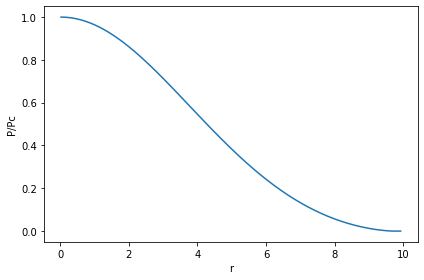

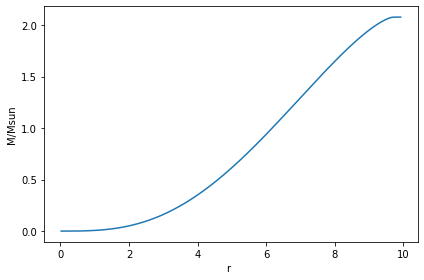

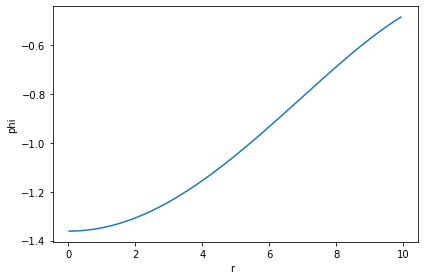

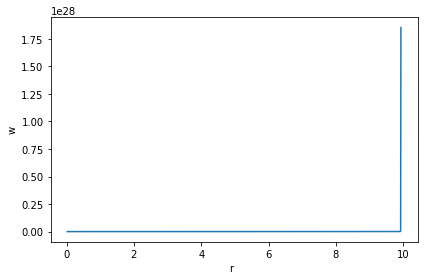

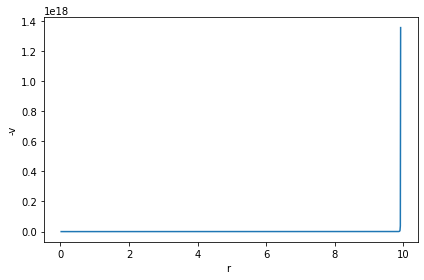

In [10]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, -v)
plt.xlabel("r ")
plt.ylabel("-v")
plt.show()

In [11]:
# plt.plot(p/p_c, EOS(p))

In [12]:
# # Delete when shifting over to python
# old_backend = mpl.get_backend() 
# %matplotlib notebook 
# # ====================================================================================
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()
# fig.show()
# fig.canvas.draw()
# plt.xlabel("f-mode (omega)")
# plt.ylabel("boundary value")

# def minimize_boundary(omega, p = p, EOS = EOS):
#     # Repeat integration

#     W0 =  C   * r_i ** (l+1)
#     V0 = -C/l * r_i ** (l)

#     init_VEC = [p_c, m0, phi0, W0, V0]
#     msun = 2e33
#     p_min = min(p)
#     M_guess = m_R
#     R_guess = r_R

#     # Integrate
#     p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = False, 
#                                  l = l)

#     loss = abs(boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R))
#     ax.scatter(omega/(2*np.pi), loss, color = "dodgerblue", marker = "x")
#     fig.canvas.draw()
#     return loss

# omega_guess = 1e3*(2*np.pi)
# res = minimize(minimize_boundary, x0 = omega_guess, method='Nelder-Mead', 
#                options = {"disp": True, "maxiter":10},
#                tol = 1e1)

# mpl.use(old_backend) # Delete when shifting over to python

In [13]:
# # Final Integration
# omega = res.x[0]
# C = 1 # Arbitrary constant

# W0 =  C   * r_i ** (l+1)
# V0 = -C/l * r_i ** (l)

# init_VEC = [p_c, m0, phi0, W0, V0]
# msun = 2e33
# p_min = min(p)
# M_guess = m_R
# R_guess = r_R
# time.sleep(0.2)

# # Integrate
# p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

# max_idx = np.argmax(m)
# m_R = m.max() # In units of msun
# r_R = r_arr[max_idx] # In units of km
# p_R = p[max_idx] #cgs
# ec_R = EOS(p_R) #cgs
# phi_R = phi[max_idx] #cgs

# schild = (1-2*G*m_R/(c**2*r_R))
# interior = np.exp(2*phi[-1])

# print("== Final Integration == ")
# print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
# print(f"Interior Surface: {interior:.4f}")
# print(f"Exterior Surface: {schild:.4f}")
# print(f"Phi0 Round: {phi0}")
# print(f"Lamda Round: {lamba_metric(m_R, r_R)}")
# print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

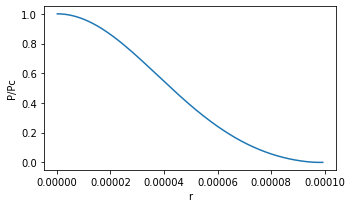

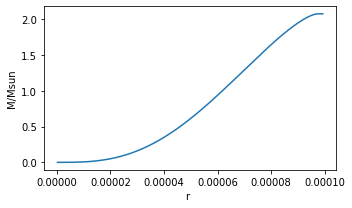

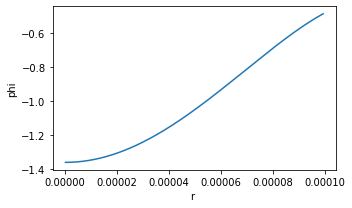

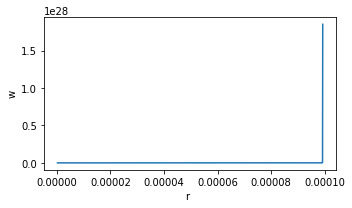

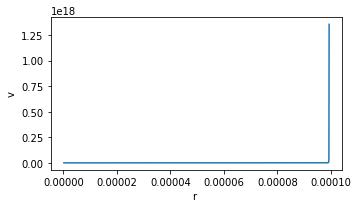

In [14]:
mpl.rcParams['figure.figsize'] = (5, 3)
r_arr = r_arr/km2cm


plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, -v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

The fact that v, w are oscillating so much implies that a change in sign of W could easily have huge impacts on the value of the boundary term. Should w be smooth? V, W have approximately the same oscillation rates hence do we expect them to cancel out each other. 

In [15]:
# If w, v at R have opposite sign, print 1, else print -1
print(-np.sign(v_R)*np.sign(w_R))

1.0


In [16]:
# F MODE IS 2PI * OMEGA 